In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jaxopt
jax.config.update("jax_enable_x64", True)
from functools import partial

import tinygp
from tinygp import kernels, GaussianProcess



/Users/vincent/.local/share/virtualenvs/tinygp-wX4-o_8N/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import matplotlib.pyplot as plt # separate from above because JAX
plt.rcParams["figure.figsize"] = (12, 8)

SOLAR LCOE (2019 USD/KWH)

Variable time span	2010 – 2019

Data published by	: IRENA (2020), Renewable Power Generation Costs in 2019, International Renewable Energy Agency, Abu Dhabi.

Link	https://www.irena.org/publications/2020/Jun/Renewable-Power-Costs-in-2019

In [3]:
sol_2019_usd_per_kWh = 100*np.array([0.3783, 0.2863, 0.2225, 0.1751, 0.1636, 0.1264, 
                                     0.1139, 0.0924, 0.0787, 0.0684])
sol_2019_usd_per_kWh

array([37.83, 28.63, 22.25, 17.51, 16.36, 12.64, 11.39,  9.24,  7.87,
        6.84])

With this [infographic](https://www.irena.org/newsroom/articles/2020/Jun/How-Falling-Costs-Make-Renewables-a-Cost-effective-Investment) the data is not as precise, but more recent. 

I've extracted it from the js object

In [4]:
t = np.linspace(2010, 2021, 12)
sol_2019 = np.array([37.8, 28.6, 22.3, 17.5, 16.4, 12.6, 11.4, 9.2, 7.9, 6.8, 4.5, 3.9])

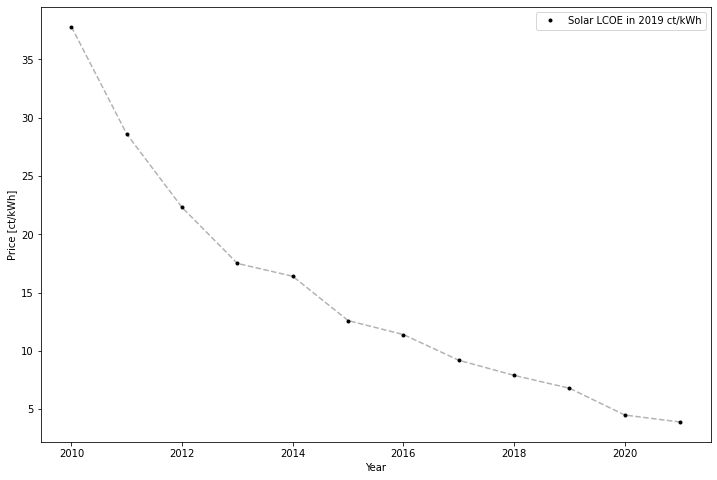

In [8]:
plt.plot(t, sol_2019, ".k", label="Solar LCOE in 2019 ct/kWh"); #plt.xticks(t)
plt.plot(t, sol_2019, "k--", alpha=0.3)
plt.xlabel("Year"); plt.ylabel("Price [ct/kWh]"); plt.legend(); 

In [9]:
def build_gp(params):
    kernel = jnp.exp(params["log_amp_poly"]) * kernels.Polynomial(order=params["poly_order"], 
                                                                 scale=params["log_poly1_scale"], 
                                                                 sigma=params["log_poly1_sigma"])
    kernel2 = jnp.exp(params["log_amp1"]) * kernels.ExpSquared(jnp.exp(params["log_scale1"]))
    return GaussianProcess(
        kernel2, 
        t, 
        diag=0.14**2 + jnp.exp(params["log_jitter"])
    )

@jax.jit
def loss(params):
    gp = build_gp(params)
    return -gp.log_probability(sol_2019)
    

params = {
    "log_jitter": 0.15, 
    "log_amp_poly": np.log(5.), 
    "poly_order": 2., 
    "log_poly1_scale": np.log(2.0),
    "log_poly1_sigma": np.log(2.0), 
    "log_amp1": np.log(np.var(sol_2019)), 
    "log_scale1": np.log(1.0),
}
loss(params)

DeviceArray(45.9494067, dtype=float64)

In [10]:
import jaxopt

solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(jax.tree_map(jnp.asarray, params))
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 29.555010662627986


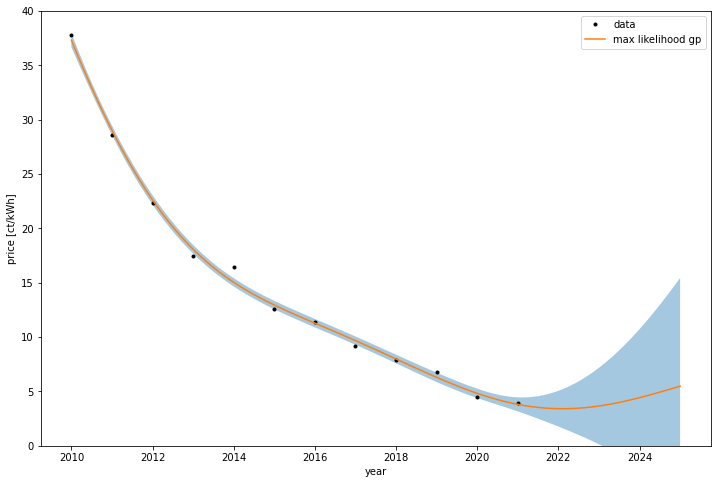

In [11]:
tt = np.linspace(2010, 2025, 100)
_, cond = build_gp(soln.params).condition(sol_2019, tt)

mu, std = cond.loc, np.sqrt(cond.variance)
plt.plot(t, sol_2019, ".k", label="data")
plt.plot(tt, mu, color="C1", label="max likelihood gp")
plt.fill_between(tt, mu-std, mu+std, alpha=0.4)
plt.xlabel("year"); plt.ylabel("price [ct/kWh]")
plt.ylim(0, 40)
plt.legend()

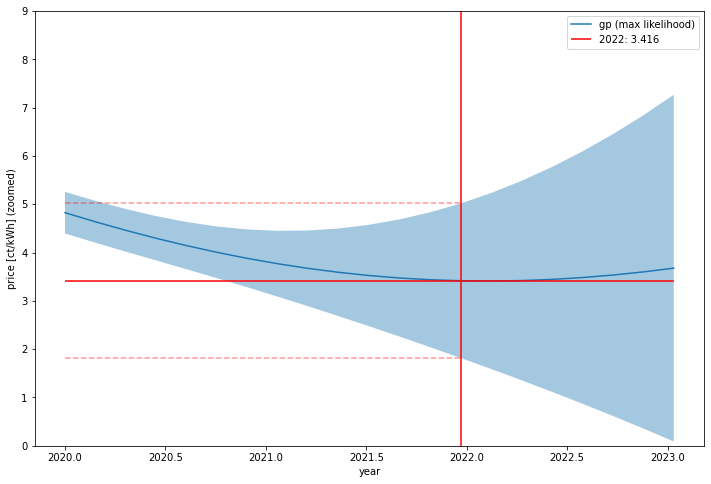

In [18]:
ti1, ti2, tc = 66, 87, 79
plt.plot(tt[ti1:ti2], mu[ti1:ti2], label="gp (max likelihood)")
plt.fill_between(tt[ti1:ti2], mu[ti1:ti2]-std[ti1:ti2], mu[ti1:ti2]+std[ti1:ti2], alpha=0.4)
plt.ylim(0, 9)
plt.vlines(tt[tc], 0, 9, color="red", label="2022: {:.3f}".format(mu[tc]))
plt.hlines(mu[tc], tt[ti1], tt[ti2-1], color="red")
plt.hlines(mu[tc]-std[tc], tt[ti1], tt[tc], linestyles="--", color="red", alpha=0.4)
plt.hlines(mu[tc]+std[tc], tt[ti1], tt[tc], linestyles="--", color="red", alpha=0.4)
plt.ylabel("price [ct/kWh] (zoomed)"); plt.xlabel("year"); plt.legend()

In [14]:
print(f"Standard deviation at 2022's prediction: {std[tc]}")

Standard deviation at 2022's prediction: 1.5988303995567092


## Older data (?) Weirder for sure

Especially weird that I cannot recall where I got some of this

Source: https://datasetsearch.research.google.com/search?src=0&query=price%20solar&docid=L2cvMTFqY2p6NF9xcQ%3D%3D

### Reporting Year (US-ct $/ W_{DC}$) 

Residential (22-panel)
9.01 7.83 5.35 4.60 4.00 3.71 3.44 3.12 2.90 2.84 2.71 2.65 

Commercial Rooftop (200-kW) 
6.67 6.13 4.08 3.26 3.21 2.64 2.50 2.07 1.84 1.80 1.72 1.56 

Utility-Scale (100-MW fixed-tilt) 
5.69 4.83 3.17 2.39 2.19 2.12 1.67 1.15 1.13 0.97 0.94 0.83 

Utility-Scale (100-MW one-axis tracking)
6.78 5.66 3.76 2.81 2.49 2.29 1.77 1.24 1.21 1.04 1.01 0.89

In [14]:
# To be honest, I do not remember where this series came from

sol = np.array([31.8, 26.3, 18.0, 13.6, 11.9, 10.7, 8.5, 6.5, 6.2, 5.2, 5.2]) #rate_ct_per_kWh
t = np.linspace(2010, 2020, len(sol))
sol

array([31.8, 26.3, 18. , 13.6, 11.9, 10.7,  8.5,  6.5,  6.2,  5.2,  5.2])

In [15]:
def mean_function(params, t): 
    f = jnp.exp(
            - mean_params["scale"] * (t-mean_params["loc"])
    )
    beta = jnp.array([1, f])
    return params["amps"] @beta # @ is essentially .*

mean_params = {
    "amps": np.array([5, 30.0]), #30
    "loc": 2009.5, # 2010
    "scale": 0.35,
}
#X = np.linspace(min(t), max(t)+5, 100)

In [16]:
model = jax.vmap(partial(mean_function, mean_params))(t)

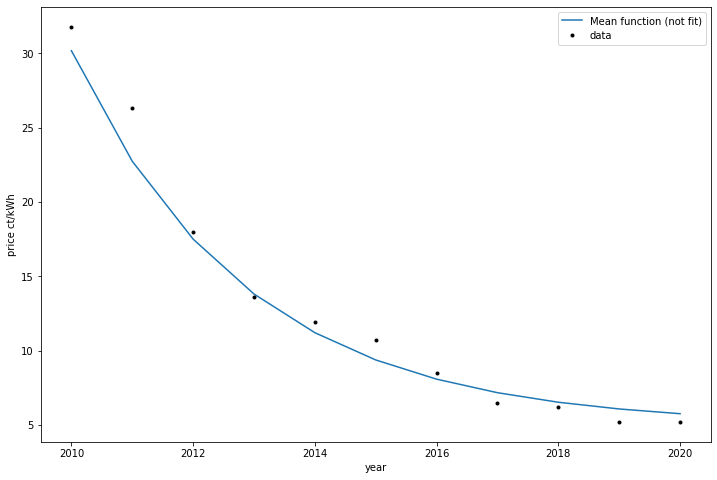

In [17]:
plt.plot(t, model, label="Mean function (not fit)")
plt.plot(t, sol, ".k", label="data")
plt.xlabel("year"); plt.ylabel("price ct/kWh"); plt.legend()

In [18]:
(sol/1.2) @ (sol/1.2)

1857.6458333333335

In [19]:
np.ndim(sol@sol)

0

In [20]:
sek = kernels.ExpSquared(scale=1.0)

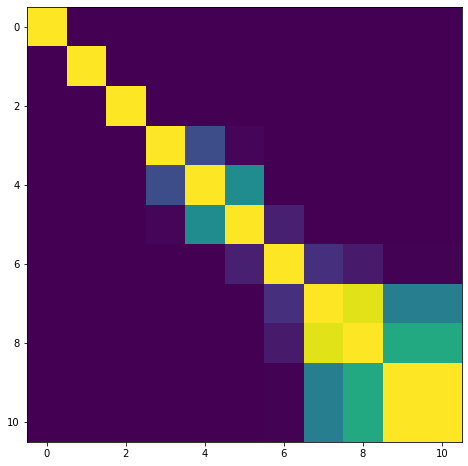

In [21]:
plt.imshow(sek(sol, sol))

In [22]:
np.median(sol)

10.7

In [23]:
def build_gp_meanfn(params):
    kernel = jnp.square(params["log_amp1"]) * kernels.ExpSquared(jnp.exp(params["log_scale1"])) 
    kernel2 = jnp.exp(params["const1"])
    kernel = kernel + kernel2
    return GaussianProcess(
        kernel, 
        t, 
        diag= jnp.square(jnp.exp(params["log_noise"])) + jnp.exp(params["log_jitter"]), 
        mean = partial(mean_function, params)
    )

@jax.jit
def loss(params):
    gp = build_gp_meanfn(params)
    return -gp.log_probability(sol)
    

params = {
    "log_noise": .4,
    "log_jitter": .5, 
    "const1": np.log(1.4),
    "log_amp1": np.log(3.0), 
    "log_scale1": np.log(1.76),
    **mean_params
}

In [24]:
print(f"Initial negative log likelihood: {loss(params)}")
solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(jax.tree_map(jnp.asarray, params))
print(f"Final negative log likelihood: {soln.state.fun_val}")

Initial negative log likelihood: 20.94669167365103
Final negative log likelihood: 13.819773008086397


In [25]:
soln.params

{'amps': DeviceArray([ 4.58712824, 33.58645166], dtype=float64),
 'const1': DeviceArray(-21.06814923, dtype=float64),
 'loc': DeviceArray(2009.5, dtype=float64),
 'log_amp1': DeviceArray(2.00363571e-07, dtype=float64),
 'log_jitter': DeviceArray(-0.46616323, dtype=float64),
 'log_noise': DeviceArray(-1.17701399, dtype=float64),
 'log_scale1': DeviceArray(3.20226047, dtype=float64),
 'scale': DeviceArray(0.35, dtype=float64)}

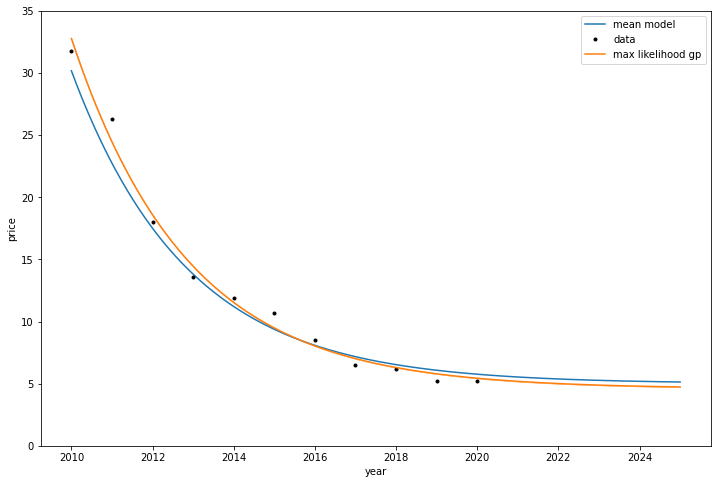

In [26]:
tt = np.linspace(2010, 2025, 500)
_, cond = build_gp_meanfn(soln.params).condition(sol, tt)

model_tt = jax.vmap(partial(mean_function, mean_params))(tt)

plt.plot(tt, model_tt, label="mean model")
mu, std = cond.loc, np.sqrt(cond.variance)
plt.plot(t, sol, ".k", label="data")
plt.plot(tt, mu, color="C1", label="max likelihood gp")
plt.fill_between(tt, mu-std, mu+std,color="C1", alpha=0.4)
plt.xlabel("year"); plt.ylabel("price")
plt.ylim(0, 35)
plt.legend()

In [27]:
def build_gp(params):
    kernel = jnp.exp(params["log_amp_poly"]) * kernels.Polynomial(order=params["poly_order"], 
                                                                 scale=params["log_poly1_scale"], 
                                                                 sigma=params["log_poly1_sigma"])
    kernel2 = jnp.exp(params["log_amp1"]) * kernels.ExpSquared(jnp.exp(params["log_scale1"]))
    return GaussianProcess(
        kernel2, 
        t, 
        diag=0.14**2 + jnp.exp(params["log_jitter"])
    )

@jax.jit
def loss(params):
    gp = build_gp(params)
    return -gp.log_probability(sol)
    

params = {
    "log_jitter": 0.15, 
    "log_amp_poly": np.log(5.), 
    "poly_order": 2., 
    "log_poly1_scale": np.log(2.0),
    "log_poly1_sigma": np.log(2.0), 
    "log_amp1": np.log(np.var(sol)), 
    "log_scale1": np.log(1.0),
}
loss(params)

DeviceArray(40.3848687, dtype=float64)

In [28]:
import jaxopt

solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(jax.tree_map(jnp.asarray, params))
print(f"Final negative log likelihood: {soln.state.fun_val}")


Final negative log likelihood: 26.632411236651834


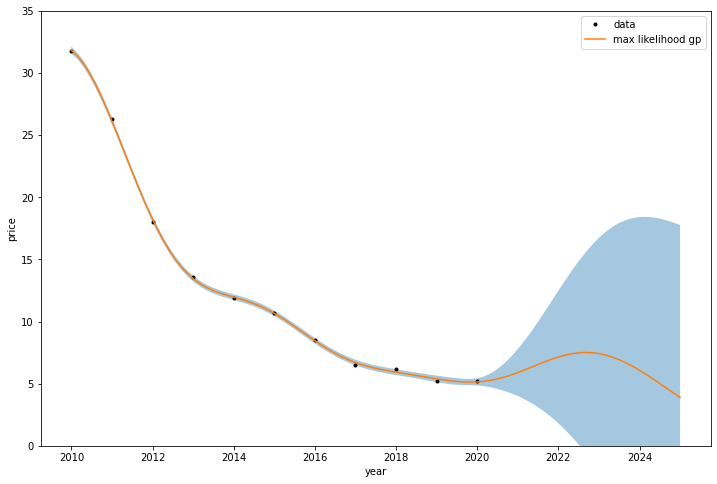

In [29]:
tt = np.linspace(2010, 2025, 100)
_, cond = build_gp(soln.params).condition(sol, tt)

mu, std = cond.loc, np.sqrt(cond.variance)
plt.plot(t, sol, ".k", label="data")
plt.plot(tt, mu, color="C1", label="max likelihood gp")
plt.fill_between(tt, mu-std, mu+std, alpha=0.4)
plt.xlabel("year"); plt.ylabel("price")
plt.ylim(0, 35)
plt.legend()

Length of the covariance vector: 100
Plot: 


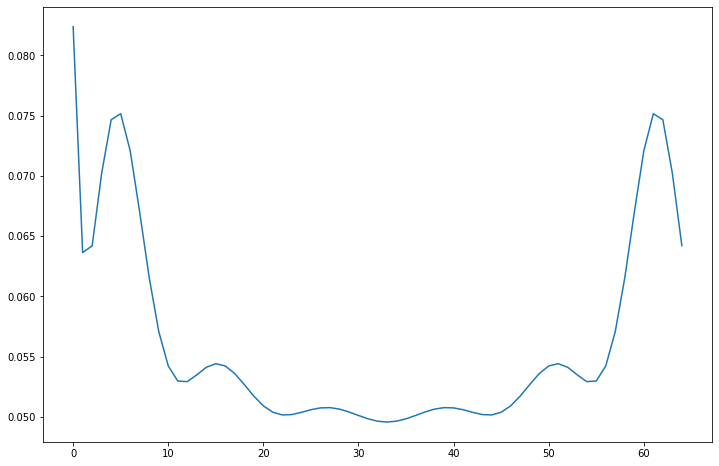

In [30]:
print(f"Length of the covariance vector: {len(cond.variance)}")
print("Plot: ")
plt.plot(cond.variance[:-35]);

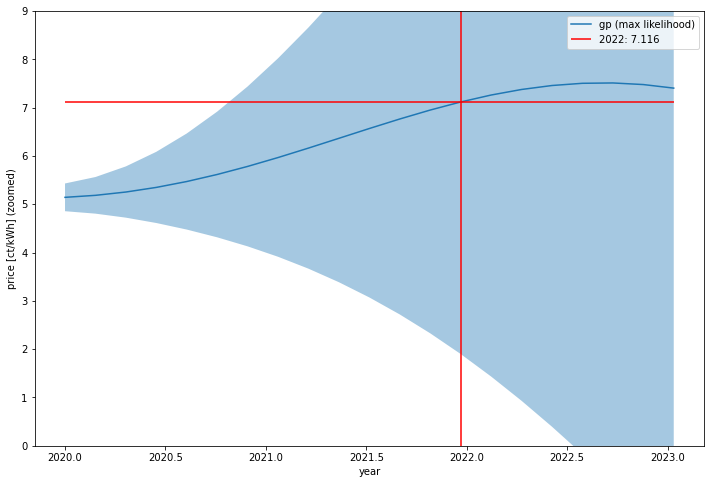

In [31]:
ti1, ti2, tc = 66, 87, 79
plt.plot(tt[ti1:ti2], mu[ti1:ti2], label="gp (max likelihood)")
plt.fill_between(tt[ti1:ti2], mu[ti1:ti2]-std[ti1:ti2], mu[ti1:ti2]+std[ti1:ti2], alpha=0.4)
plt.ylim(0, 9)
plt.vlines(tt[tc], 0, 9, color="red", label="2022: {:.3f}".format(mu[tc]))
plt.hlines(mu[tc], tt[ti1], tt[ti2-1], color="red")
plt.ylabel("price [ct/kWh] (zoomed)"); plt.xlabel("year"); plt.legend()

In [32]:
np.mean(sol)

13.08181818181818